# Исследование объявлений о продаже квартир

Провести исследовательский анализ датасета с объявлениями о продаже квартир в Санкт-Петербурге и области, выявить параметры, определяющие стоимость квартиры. 

### Оглавление
 - [Шаг 1. Откроeм файл с данными и изучим общую информацию. ](#1)
 - [ Шаг 2. Предобработка данных](#2) 
 - [ Шаг 3. Расчет и добавление значений в таблицу, замента пропусков площади](#3)
 - [Шаг 4. Исследовательский анализ данных ](#4)
    - [Анализ площади, цены, числа комнат, высоты потолков](#4.1)
    - [Цена](#4.2)
    - [Анализ времени продажи](#4.3)
    - [Какие факторы больше всего влияют на стоимость квартиры?](#4.4)
    - [Анализ топ-10 населённых пунктов с наибольшим числом объявлений](#4.5)
    - [Квартиры в центре Санкт-Петербурга](#Spb)
    
- [Шаг 5. Общий вывод](#5)

### Шаг 1. Откроeм файл с данными и изучим общую информацию. <a class="anchor" id="1"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import math
import seaborn as sns 
data=pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
print(data.info())
data.describe()
data['is_apartment'].isna().count()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

23699

<H3>Общая информация о данных</H3>

В целом данные распределены неравномерно, наибольшее отклонение относительно среднего значения у <i>last_price и days_exposition</i>,  эти столбцы придется долго очищать от выбросов.

В данных много пропусков, больше всего в столбцах <i>ceiling_height, is_apartment, balcony, parks_nearest, ponds_nearest</i>. Именно в них и постараемся в первую очередь устранить NaN.

Также в глаза бросается несоответствие типов и категорий данных, преобразуем:

<list>
<li>в формат date/time -- first_day_exposition

<li>в bool - is_apartment

<li>в int  -- floors_total, balcony, parks_around3000, ponds_around3000,days_exposition. 
<br><i>#поскольку эти столбцы еще не очищены от NAN, то перевести  в int получается только часть строк (не NaN) </i></list>

## Шаг 2. Предобработка данных <a class="anchor" id="2"></a>

### 2.1 Замена NaN

In [2]:

data['is_apartment'].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

Mожно все пропуски в is_apartment заполнить False, поскольку  большая часть квартир очевидно принадлежит жилому фонду, но не будет ли это искажением данных (как и в случае с потолками)? Хотя мы не анализируем цену по этому параметру в проекте, но могли бы.

In [3]:
#замена пропусков в is_apartment на False
data['is_apartment']=data['is_apartment'].fillna(0)

Создадим полный дубликат исходного датафрема, чтобы править в нем данные.

In [4]:
#заменим пропуски в числе балконов на 0
data['balcony']=data['balcony'].fillna(0)

Примем что, если значение в parks_around3000 пропущено, но в радиусе 3000 парков нет. Заменим пропуски в parks_around3000 на 0. 
Аналогично поступим с ponds_around3000.

In [5]:
data['parks_around3000']=data['parks_around3000'].fillna(0)
data['ponds_around3000']=data['ponds_around3000'].fillna(0)

### 2.2 Преобразование типов данных 

In [7]:
# преобразуем дату размещения объявления к красивому формату
data['first_day_exposition']=pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

#преобразуем  is_apartment к булевому типу
data['is_apartment']=data['is_apartment'].astype('bool')

#преобразуем цифры в floors_total, balcony, parks_around3000, ponds_around3000,days_exposition к  типу int
cols=['floors_total', 'balcony', 'parks_around3000', 'ponds_around3000', 'days_exposition']
data[cols]=data[cols].apply(pd.to_numeric, errors= 'coerce').where(data[cols].notna())

#check
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 23699 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        23699 non-null float64
parks_nearest           8079 non-null float64
ponds_ar

### Шаг 3. Расчет и добавление значений в таблицу, замента пропусков площади <a class="anchor" id="3"></a>


Добавим в таблицу:
<li>цену квадратного метра;
<li>день недели, месяц и год публикации объявления;
<li>этаж квартиры; варианты — первый, последний, другой;
<li>соотношение жилой и общей площади, а также отношение площади кухни к общей.

In [8]:
#цена квадратного метра
data['meter_price']=data['last_price']/data['total_area']

In [9]:
#день недели, месяц и год публикации объявления
data['year']=data['first_day_exposition'].dt.year
data['month']=data['first_day_exposition'].dt.month
data['weekday']=data['first_day_exposition'].dt.weekday

In [10]:
#этаж квартиры
def floor_type(row):
    if row['floor'] ==1 or row['floors_total']==1:
        return 'first'
    elif row['floor']  == row['floors_total'] and row['floors_total']>1:
        return 'last'
    else:
        return 'other'

    
data['floor_type']=data.apply(floor_type, axis=1)
data[['floor', 'floors_total', 'floor_type']].head(5)

,floor,floors_total,floor_type
0,8,16.0,other
1,1,11.0,first
2,4,5.0,other
3,9,14.0,other
4,13,14.0,other


In [11]:
#соотношение жилой и общей площади
data['live_ratio']=data['living_area']/data['total_area']

#соотношение площади кухни к общей
data['kitchen_ratio']=data['kitchen_area']/data['total_area']

data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,meter_price,year,month,weekday,floor_type,live_ratio,kitchen_ratio
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,...,2.0,755.0,NaN,120370.370370,2019,3,3,other,0.472222,0.231481
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,False,...,0.0,NaN,81.0,82920.792079,2018,12,1,first,0.460396,0.272277
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,False,...,2.0,574.0,558.0,92785.714286,2015,8,3,other,0.612500,0.148214
3,0,64900000.0,159.0,2015-07-24,3,NaN,14.0,NaN,9,False,...,3.0,234.0,424.0,408176.100629,2015,7,4,other,NaN,NaN
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,...,1.0,48.0,121.0,100000.000000,2018,6,1,other,0.320000,0.410000


In [13]:
#удаление полных дубликатов (не оказалось)
data=data.drop_duplicates()

#проверка номера комнат для квартир студий
data.loc[data['studio']==True, 'rooms']=0

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23699 entries, 0 to 23698
Data columns (total 29 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 23699 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        23699 non-null float64
parks_nearest           8079 non-null float64
ponds_ar

Пропущенных значений стало  меньше. И хотя полностью избавиться от пропусков не удалось, их доля осталась на такой значительной, как была.

## Шаг 4. Исследовательский анализ данных  <a class="anchor" id="4"></a>

### Анализ площади, цены, числа комнат, высоты потолков <a class="anchor" id="4.1"></a>

<H4>Площадь</H4>

    В выборке есть 0,2% квартир больше 250 метров,  это не должно повлиять на исследование. Минимальная площадь 12 метров что соответвует квартирам-студиям. Распределение похоже на нормальное.


Минимальная площадь квартиры 12.0 кв.метров
В 0.18% квартир общая площадь больше 250 кв.метров


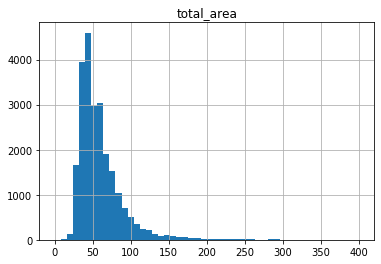

In [15]:
#гистограмма площади
data.hist('total_area', bins=50, range=(0,400))
print('Минимальная площадь квартиры', data['total_area'].min(),'кв.метров')
print('В {:.2%} квартир общая площадь больше 250 кв.метров'.format(len(data.query('ceiling_height>4.5'))/len(data)))


<H4>Количество комнат</H4>

В выборке есть незначительный процент квартир (0,1%) с больше чем 7 комнатами и 0.83% с 0 комнатами, что соответствует квартирам-студиям. Распределение похоже на нормальное.

#гистограмма числа комнат
data.hist('rooms', bins=30)
print('Больше 7 комнат в {:.2%} квартир'.format(len(data.query('rooms>7'))/len(data)))
print('Больше 1 комнаты в {:.2%} квартир'.format(len(data.query('rooms<1'))/len(data)))


<H4>Потолки</H4>

В выборке есть незначительный процент квартир (0,18%) со слишком высокими потолками и 0.01% со слишком низкими. Скорее всего высота потолков ограничена стандартами строительства.

#гистограмма высоты потолков
data.hist('ceiling_height', bins=50, range=(0,8))
print('Потолки выше 4.5 метров в {:.2%} квартир'.format(len(data.query('ceiling_height>4.5'))/len(data)))
print('Потолки ниже 2 метров в {:.2%} квартир'.format(len(data.query('ceiling_height<2'))/len(data)))


<h3>Цена</h3> <a class="anchor" id="4.2"></a>

Построим гистаграмму стоимости квардратного метра и оценим %% квартир с неправдоподобно высокой и низкой ценой за метр.
За пороговое значение слишком низкой стоимости примем границу усов. Верхнюю границу возьмем чуть выше, т.к.внутри выборки может быть класс немногочисленного элитного жилья, который считывается как выброс. Распределение нормальное.

В 1.16% квартир стоимость м2 больше 250 тыс. рублей
В 1.19% квартир стоимость м2 меньше 25 тыс. рублей


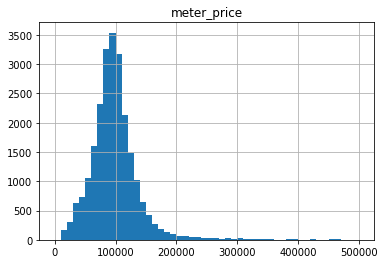

In [16]:
data.hist('meter_price', bins=50, range=(0,500000))
print('В {:.2%} квартир стоимость м2 больше 250 тыс. рублей'.format(len(data.query('meter_price>250000'))/len(data)))
print('В {:.2%} квартир стоимость м2 меньше 25 тыс. рублей'.format(len(data.query('meter_price<25000'))/len(data)))


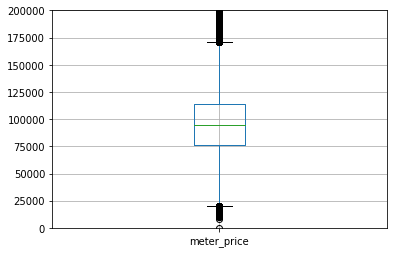

In [17]:
plt.ylim(0,200000)
data.boxplot('meter_price')

Очистим данные от найденных аномалий.

In [18]:
good_data=(data
               .query('total_area<250')
#               .query('rooms<7')
#               .query('ceiling_height>2&ceiling_height<4.5')
               .query('meter_price>25000&meter_price<250000')
          )
print('Исключено {:.2%} из выборки'.format(1-len(good_data)/len(data)))
print('Осталось строк:{}'.format(len(good_data)))

Исключено 2.77% из выборки
Осталось строк:23043


<H3>Анализ времени продажи</H3> <a class="anchor" id="4.3"></a>

Среднее значение сильно отличается от медианного, это говорит о большом разбросе значений и большом количестве выбросов.

In [19]:
print('Среднее время продажи - ', good_data['days_exposition'].mean().astype(int), 'дня\nМедиана - ', int(good_data['days_exposition'].median()))


Среднее время продажи -  179 дня
Медиана -  95


Построим гистрограмму и диаграмму квартильного размаха для времени продажи

plt.ylim(0,1200)
good_data.boxplot('days_exposition')

good_data.hist('days_exposition', bins=100, range=(0,200), figsize=(15,5), grid=True)

Получается диграмма Пуассона, пики приходятся на 45 дней, 60 дней и 90 дней, что кратно срокам публикации на Яндекс.Недвижимость. 

Смущают только слишком долгие периоды по несколько лет и слишком короткие меньше 10 дней. 

Сколько их?

In [20]:
print('{:.2%} объявлений размещалось больше 2 лет'.format(len(good_data.query('days_exposition>730'))/len(good_data)))
print('{:.2%} объявлений размещалось меньше 10 дней'.format(len(good_data.query('days_exposition<10'))/len(good_data)))

3.12% объявлений размещалось больше 2 лет
4.80% объявлений размещалось меньше 10 дней


Аномально значений достаточно мало, можно удалить не исказив исследование.

good_data=good_data.query('10<days_exposition<730')

In [21]:
print('Исключено всего {:.2%} из сырой выборки'.format(1-len(good_data)/len(data)))
print('Осталось строк:{}'.format(len(good_data)))

Исключено всего 2.77% из сырой выборки
Осталось строк:23043


# Какие факторы больше всего влияют на стоимость квартиры?  <a class="anchor" id="4.4"></a>

In [22]:
#Изучим коэффициенты корелляции цены с остальными параметрами
good_data.corr()['last_price']

total_images           0.152234
last_price             1.000000
total_area             0.821889
rooms                  0.537101
ceiling_height         0.121179
floors_total           0.052801
living_area            0.718507
floor                  0.064986
is_apartment           0.023919
studio                -0.052517
open_plan             -0.034940
kitchen_area           0.603534
balcony                0.029205
airports_nearest      -0.036056
cityCenters_nearest   -0.337708
parks_around3000       0.273065
parks_nearest          0.033017
ponds_around3000       0.277162
ponds_nearest         -0.106051
days_exposition        0.134236
meter_price            0.643192
year                  -0.037367
month                  0.005088
weekday               -0.013290
live_ratio             0.028942
kitchen_ratio         -0.136902
Name: last_price, dtype: float64

Больше всего цена зависит от плащади и высоты потолков, во вторую очередь от наличия рядом парка или пруда. 

1) чем выше потолки и больше площадь, тем выше цена

2) чем ближе парк тем цена выше, чем ближе пруд, тем цена ниже


Построим диаграммы рассеивания для основных параметров.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbba87a0890>,
      dtype=object)

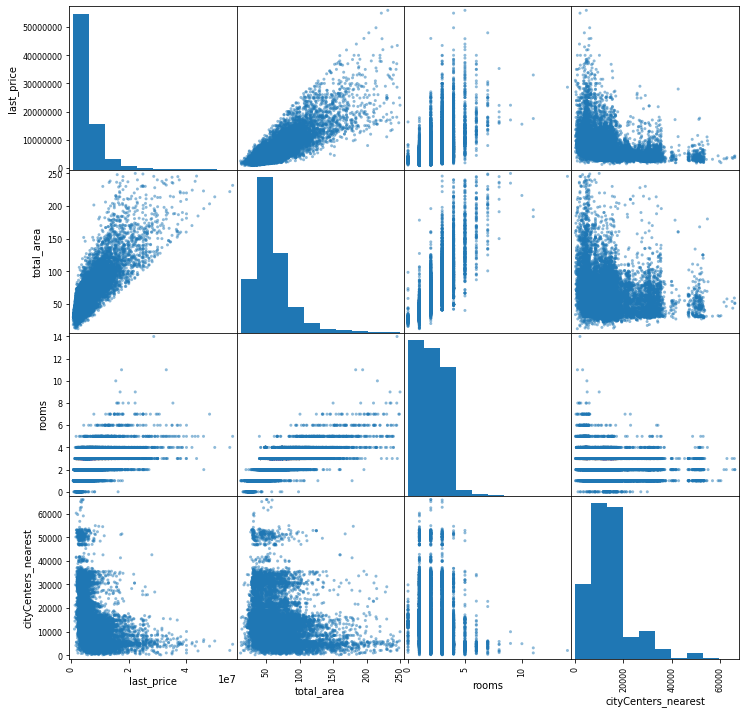

In [23]:
#площадь, числo комнат, удалённость от центра
pd.plotting.scatter_matrix(good_data[['last_price','total_area','rooms','cityCenters_nearest']] , figsize=(12, 12))

#### Вывод:
1) Больше всего квартир стоимостью до 5 миллионов, мало таких, которые дороже 10 миллионов

2) для квартир до 10 миллионов и до 4 комнат количество комнат  влияет на цену, но важнее общая площадь. Однако чем больше комнат, тем больше разброс цен и следовательно ключевая роль в формировании цены принадлежит другим параметрам жилья

3) В выборке больше всего 1-2-3 комнатных квартир

4) Самый большой разброс по цене и по площади в центре,  на окраинах в 40 километрах от центра дома больше типовые - они меньше по квадратам и стоят дешевле

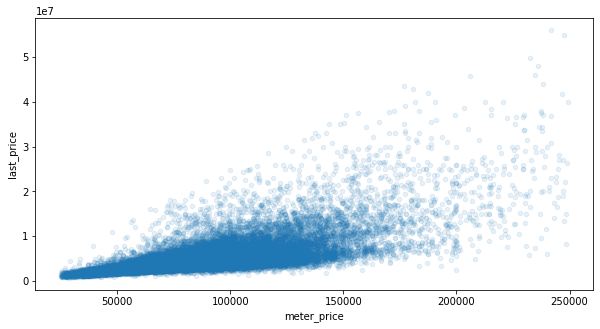

In [24]:
good_data.plot(x='meter_price', y='last_price', kind='scatter',alpha=0.1, figsize=(10,5))

#### Вывод:
1) C ростом стоимости квартиры (и следовательно увеличением ее площади) растет и цена за метр. 

2) После отметки в 150-200 тыс. руб. за метр стоимость квартиры зависит больше от других параметров жилья.

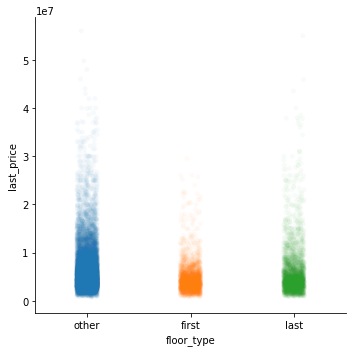

In [25]:
sns.catplot(x="floor_type", y="last_price", data=good_data, alpha=0.03);

#### Вывод:
Квартиры на первом и последнем этаже стоят дешевле, чем квартиры на других этажах.

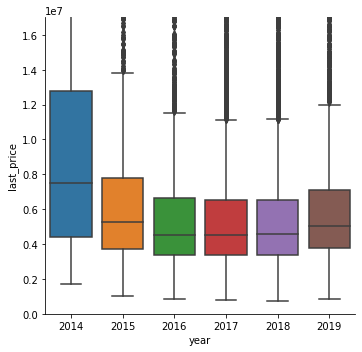

In [26]:
sns.catplot(x='year', y='last_price', kind="box", data=good_data).set(ylim=(0,17000000));

#### Вывод:
Самая высокая стоимость картир была в 2014 (это может быть связано с недостаточностью выборки).
После кризиса в 2015 годы стоимость упала и снова начала подрастать только в 2019 году. В 2020 очевидно снова упадет...

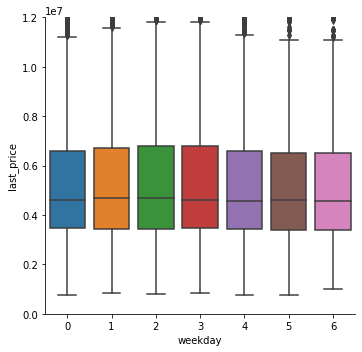

In [27]:
sns.catplot(x='weekday', y='last_price', data=good_data, kind='box').set(ylim=(0,12000000))

#### Вывод:
Стоимость квартир в объявлениях размещенных среди недели несколько выше, чем в тех, что разместили в выходные

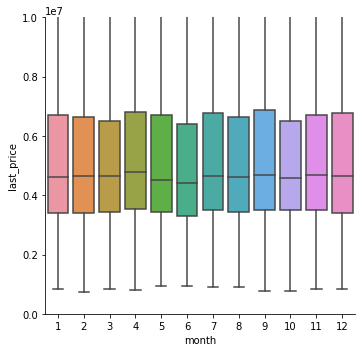

In [28]:
sns.catplot(x='month', y='last_price', data=good_data, kind='box').set(ylim=(0,10000000))

#### Вывод:
Самая низкая стоимось в объявлениях, размещенных в октябре и в теплые месяцы. Похоже, что чем более активны люди, тем выше в среднем цены на недвижимость.

###  Анализ топ-10 населённых пунктов с наибольшим числом объявлений <a class="anchor" id="4.5">

Названия населенных пунктов разнородные - в некоторых названиях присутствует тип населенного пункта, в других нет, написание одних и тех же населенных пунктов также различается из-за наличия буквы ё.
Выяделим основные типы населенных пунктов, чтобы потом исключить их из названий в отдельный столбец.

In [29]:
# создадим отдельный датафрем с названием ближайшего населенного пункта и  стоимостью квадратного метра в нем. 
cities = good_data.loc[good_data.locality_name.notna(), ['locality_name','meter_price']]


# заменим все ё на е
def dropee(string):
    string=string.replace("ё","е")
    return string
    
cities['locality_name_no_e']=cities['locality_name'].apply(dropee)

#узнаем какие слова встречаются в столбце locality_name чаще других, чтобы выделить основные типы населенных пунктов
wordcount={}
for row in cities['locality_name']:
    for word in row.lower().split():
        word = word.replace("ё","е")
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1
df_wordcount=pd.DataFrame.from_dict(wordcount, orient='index', columns=['count'])
df_wordcount.index.name='name'
df_wordcount.reset_index().sort_values(by='count', ascending=False).head(10)



,name,count
0,санкт-петербург,15356
1,поселок,2590
11,деревня,906
6,мурино,590
12,кудрово,472
2,шушары,440
37,всеволожск,397
10,пушкин,366
15,городского,337
14,колпино,337


Основных типов населенных пунктов 5 - поселок, деревня, поселок городского типа, городской поселок, село.
Создадим новый столбец в датафрейме cities, а затем: категоризируем где задан тип населенного пункта + санкт-петербург + топ-10 по популярности городов, удалим из названий найденные типы.

In [30]:
#категоризация по типу населенного пункта
def set_city_type(locality):    
    for word in locality.lower().split():
        if 'поселок' in word:
            return 'поселок'
        if 'деревня' in word:
            return 'деревня'
        if 'село' in word:
            return 'село'
        if 'санкт-петербург' in word:
            return 'санкт-петербург'
        if 'мурино' in word:
            return 'город'
        if 'кудрово' in word:
            return 'город'
        if 'шушары' in word:
            return 'поселок'
        if 'всеволожск' in word:
            return 'город'
        if 'колпино' in word:
            return 'город'
        if 'парголово' in word:
            return 'поселок'
        if 'пушкин' in word:
            return 'город'
        if 'гатчина' in word:
            return 'город'
        if 'выборг' in word:
            return 'город'
        if 'петергоф' in word:
            return 'город'
        if 'пушкин' in word:
            return 'город'
        else:
            return 'unknown'
            
cities['city_type'] = cities['locality_name_no_e'].apply(set_city_type)            

#удаление типа населенных пунктов из названий 

cities['new_locality_name'] = cities['locality_name_no_e'].apply(lambda x: x.replace('поселок городского типа','')
                                                       .replace('городской поселок','')
                                                       .replace('поселок','')
                                                       .replace('деревня','')
                                                       .replace('село',''))
cities.head(5)

,locality_name,meter_price,locality_name_no_e,city_type,new_locality_name
0,Санкт-Петербург,120370.370370,Санкт-Петербург,санкт-петербург,Санкт-Петербург
1,посёлок Шушары,82920.792079,поселок Шушары,поселок,Шушары
2,Санкт-Петербург,92785.714286,Санкт-Петербург,санкт-петербург,Санкт-Петербург
4,Санкт-Петербург,100000.000000,Санкт-Петербург,санкт-петербург,Санкт-Петербург
5,городской посёлок Янино-1,95065.789474,городской поселок Янино-1,unknown,Янино-1


Сгруппируем данные по городам и вычислим среднюю стоимость квадратного метра, выведем топ 10 самых дорогих

In [31]:
#группируем по городам, вычисляем количество объявлений и стоимость среднего метра
cities_grouped=(cities.pivot_table(index='new_locality_name', values='meter_price', aggfunc=('mean','count'))
                .reset_index()
                .sort_values(by='count', ascending=False))

#переименовка столбцов
top_10=cities_grouped[:10]
top_10.columns=['Название', 'Количество_объявлений', 'Стоимость_кв.метра']

print('10 населённых пунктов с наибольшим числом объявлений:\n\n', top_10.head(10),'\n\n')
print('Самая высокая стоимость жилья в', top_10.sort_values(by='Стоимость_кв.метра', ascending=False).iloc[0][0],'и',top_10.sort_values(by='Стоимость_кв.метра', ascending=False).iloc[1][0],'\n')
print('Самая низкая стоимость жилья в', top_10.sort_values(by='Стоимость_кв.метра', ascending=True).iloc[0][0])


10 населённых пунктов с наибольшим числом объявлений:

             Название  Количество_объявлений  Стоимость_кв.метра
259  Санкт-Петербург                  15356       109980.918558
106           Мурино                    556        85681.762601
214           Шушары                    440        78677.364217
229       Всеволожск                    397        67214.252635
258           Пушкин                    366       102711.750958
239          Колпино                    337        75333.295801
124        Парголово                    327        90175.913458
232          Гатчина                    304        69294.601730
74           Кудрово                    299        92473.547576
230           Выборг                    234        58600.353755 


Самая высокая стоимость жилья в Санкт-Петербург и Пушкин 

Самая низкая стоимость жилья в Выборг


Исследуем зависимость стоимости жилья от типа населенного пункта

,city_type,count,mean
0,санкт-петербург,15356,109980.918558
1,город,2046,79166.441656
2,поселок,2407,72437.847518
3,деревня,906,70223.806318
4,unknown,2248,61237.763298
5,село,32,48321.425937


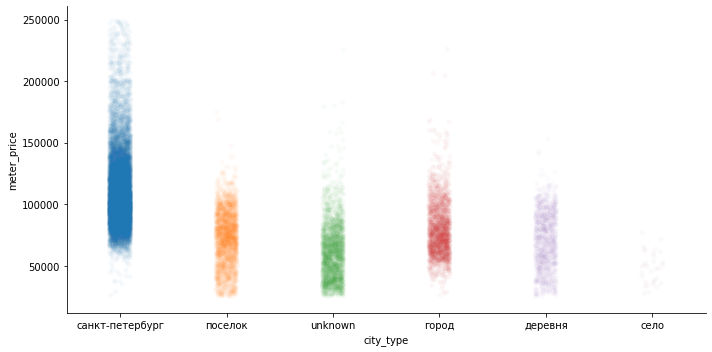

In [32]:
sns.catplot(data=cities, x='city_type', y='meter_price',height=5, aspect=2, alpha=0.03)
cities.pivot_table(index='city_type', values='meter_price', aggfunc=('mean', 'count')).sort_values(by='mean', ascending=False).reset_index()

### Выводы:

1) Самая высокая стоимость и разброс цен в Санкт-Петербурге,  в поселках и городах уровень цен практически одинаковый. 

2) Самый дорогой квадратный метр в выборке оказался в Питере и городе Пушкин, дешевле в Выборге.

3) Больше всего объявлений по Санкт-Петербургу, а средняя стоимость квадратного метра 100 тыс. руб.

### Выделим квартиры в центре Санкт-Петербурга, для этого выясним, какая область входит в центре - посчитаем как зависит цена он удаленности от центра и найдем кластеры. <a class="anchor" id="Spb"></a>

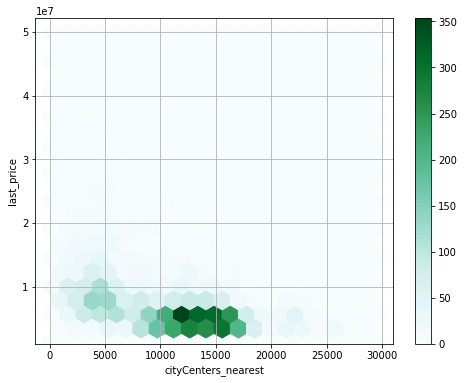

In [41]:
good_data['new_locality_name']= good_data.loc[good_data['locality_name'].notna(), 'locality_name'].apply(lambda x: x.lower())
spb_data=good_data.query('new_locality_name=="санкт-петербург"')[['locality_name','meter_price', 'last_price', 'cityCenters_nearest']].reset_index()
spb_data['cityCenters_nearest']=spb_data['cityCenters_nearest'].round()
price_for_m=spb_data.pivot_table(index='cityCenters_nearest', values='last_price').reset_index()
price_for_m=price_for_m.sort_values(by='cityCenters_nearest')
#price_for_km.plot(kind='bar', stacked=True, x='cityCenters_nearest', y='mean')
price_for_m.plot( x='cityCenters_nearest', y='last_price', kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False, grid=True, ylim=1000000)


### Вывод:

На графике выделяются два кластера значений: небольшой центр с расстоянием до 7км от центра и стоимостью  8 (+-3) млн. рублей и большой кластер окраин с расстоянием 7-20 км. от центра и стоимостью 5 млн(+-2) млн. рублей.

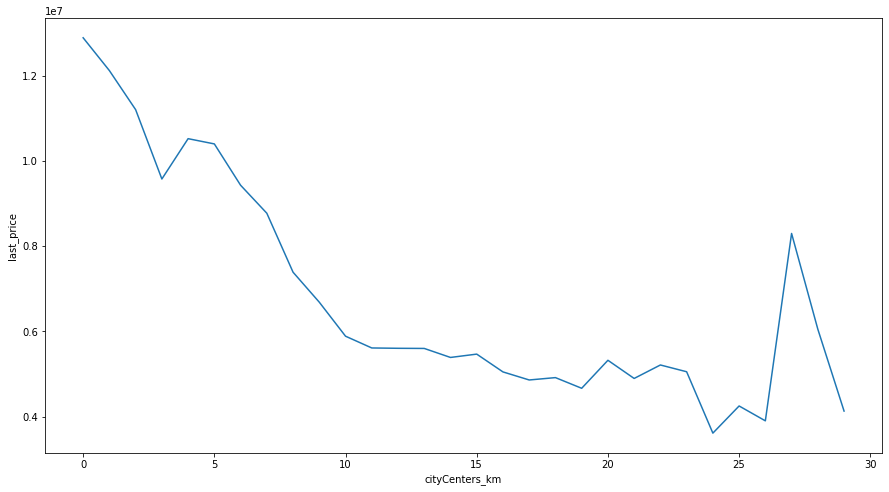

In [48]:
price_for_m['cityCenters_km']=round(price_for_m['cityCenters_nearest']/1000)
price_for_km = price_for_m.pivot_table(index='cityCenters_km', values='last_price').reset_index()

plt.figure(figsize=(15,8))
sns.lineplot(data=price_for_km, x='cityCenters_km', y='last_price')

### Проанализируем сегмент квартир в центре и выделим параметры, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сравним с остальным датасетом. <a class="anchor" id="2.6"> </a>

In [ ]:
#выделим срез объявлений с квартирами в центре Питера, то есть с расстоянием до центра города 7 км и меньше. 
#Рассчитаем коэффициенты корреляции цены с другими параметрами и сравним их с данными всей таблицы
piter_corr=good_data.query('new_locality_name=="санкт-петербург"&cityCenters_nearest<=7000').corr()['last_price'][:-1].reset_index()
data_corr=good_data.corr()['last_price'][:-1].reset_index()
compare_corr=piter_corr.merge(data_corr, how='outer', on='index', suffixes=('_piter', '_all'))
compare_corr

In [ ]:
#выделим срез объявлений с квартирами в центре Питера, то есть с расстоянием до центра города 7 км и меньше.
good_data['spb_center']=(good_data['new_locality_name']=="санкт-петербург") & (good_data['cityCenters_nearest']<=7000)
sns.pairplot(good_data, kind="reg", vars=['last_price', 'ceiling_height', 'total_area', 'rooms'], hue="spb_center", markers='+', plot_kws={'scatter_kws': {'alpha': 0.1}}) 

### Вывод:

1) Первое что бросается в глаза - площади в центре питера несколько больше и комнат больше.

2) Очевидно, что жилье в центре Питера дороже, чем в окресностях питера, поэтому гистограмма цены для центральной части смещена вправо относительно гистограммы всей таблицы

3) Цена как в центре Питера, так и в окресностях в первую очередь зависит от площади, а во вторую от высоты потолков, причем высота потолков в центре чуть выше и более универсальна и поэтому в меньшей степени влияет на цену.

4) А вот количество комнат в центре несколько больше влияет на цену, чем в окрестностях(при количестве комнат от 1 до 5).

5) цена в радиусе 7 км от центра практически не зависит от расстояния до центра

6) этажность более важна для квартир в центре, где застройка преимущественно низкоэтажная, однако и в центре питера и на окраине квартиры на более высоких этажах стоят дороже. 

7) Наличие пруда или парка в радиусе 3 км от дома повышает его цену. При это удаленность от парка практически не влияет на цену, а удаленность от пруда влияет (но не в центре).



In [ ]:
sns.pairplot(good_data, kind="reg", vars=['last_price', 'ponds_nearest', 'parks_nearest', 'parks_around3000', 'ponds_around3000'], hue="spb_center", markers='+', plot_kws={'scatter_kws': {'alpha': 0.1}}) 

In [ ]:
# посмотрим факторы которые влияют на цену на окраинах Питера и за его пределами - преимущественно в небольших городах и поселках

sbp_sub_corr=good_data.query('new_locality_name=="санкт-петербург"&cityCenters_nearest>7000').corr()['last_price'][:-1].reset_index()
other_corr=good_data.query('~(new_locality_name=="санкт-петербург")').corr()['last_price'][:-1].reset_index()

compare_all_corr=(data_corr.merge(piter_corr, how='outer', on='index', suffixes=('_all','_pitercenter'))
                            .merge(sbp_sub_corr, how='outer', on='index', suffixes=('','_sub'))
                            .merge(other_corr, how='outer', on='index', suffixes=('', '_other')))
compare_all_corr


In [ ]:
#по центру питера
piter_data=good_data.query('new_locality_name=="санкт-петербург"&cityCenters_nearest<7000').reset_index()
piter_data.describe()

In [ ]:
#сравним с остальной выборкой
not_piter_center=good_data.query('~(new_locality_name=="санкт-петербург"&cityCenters_nearest<7000)').reset_index()
print(piter_data.describe())
piter_data.describe()/not_piter_center.describe()

Типичные карактеристики квартир в центре - высокая цена (минимум в 1,5 раза выше, чем за аналогичную квартиру не в центре), большая площадь, высокие потолки, низкая этажность домов.


In [ ]:
#чтобы построить сравнительные боксплоты 
#для основных параметров добавим в  табоицу good_data новый столбец с маркером центра питера
good_data['piter_center']= ((good_data['new_locality_name']=="санкт-петербург")& (good_data['cityCenters_nearest']<7000)).astype(bool)


In [ ]:
sns.catplot(data=good_data,y='last_price', kind='box', x='piter_center').set(ylim=(0,30000000))

Разброс цен в центре выше, однако в целом квартиры значительно дороже, большая часть стоит выше 7 миллионов

In [ ]:
sns.catplot(data=good_data,y='total_area', kind='box', x='piter_center').set(ylim=(0,300))

Аналогичная ситуация с площадью. Большая часть квартир в питере имеет площать больше 60 метров, в то время как для остальной выборки 1q = 40 метров

In [ ]:
sns.catplot(data=good_data,y='ceiling_height', kind='box', x='piter_center').set(ylim=(0,5))

В центре питера потолки не ниже 2.5м, в то время как в остальных квартирах встречаются и более низкие потолки 

In [ ]:
sns.catplot(data=good_data,y='floors_total', kind='box', x='piter_center').set(ylim=(0,30))

In [ ]:
квартиры в центре находятся в домах до 13 этажей, а в больщинстве случаев до 7 этажей.

#### Вывод:

1) Стоимость за пределами Питера, как и в Питере зависит от площади, однако также  зависит от года и сезона

2) На стоимость за пределами питера практически не влияет расстояние до пруда, но его наличие в презелах 3км скорее положительно скажется на цене

3) наличие парка или пруда рядом сильнее влияют на цену

4) а вот значимость наличия балкона и этажности становится ниже в формировании цены

## Шаг 5. Общий вывод <a class="anchor" id="5"></a>

1) Цена недвижимости вне зависимости от ее расположения тем выше, чем больше площадь и количество комнат.

2) Объявления для центра крупного города и его окраин, а также для небольших городов и деревень необходимо аналилизировать раздельно, т.к. набор второстепенных параметров, принимающих участие в формировании цены  может отличаться.

3) Например, центре крупного города после площади и комнат, больше всего на стоимость влияет этаж

4) На окраинах важна высота потолков

5) В небольних городах -- наличие парка и пруда, а также сезон

<b>6) Жилье в центре Питера стоит дороже(от 7 миллионов), больше по площади (от 60 метров), с высотой потолков не меньше 2.5 метра и общим количеством этажей меньше 13.</b>

